#### Name: .Johana Cómbita Niño..

In [15]:
import numpy as np
import tensorflow as tf
import keras

from keras.datasets import mnist
from tensorflow import keras
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split



In [ ]:
# cargando datos
# Ruta del dataset descargado
DATASET_PATH = "archive/chest_xray"

# Tamaño de las imágenes
IMG_SIZE = (150, 150)

def load_data(directory):
    """
    Carga imágenes desde un directorio, asignando etiquetas 0 (Normal) y 1 (Pneumonia).
    Devuelve las imágenes y etiquetas en arrays numpy.
    """
    images, labels = [], []
    
    for label, category in enumerate(["NORMAL", "PNEUMONIA"]):  # 0 -> NORMAL, 1 -> PNEUMONIA
        folder_path = os.path.join(directory, category)
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            image = load_img(img_path, target_size=IMG_SIZE)  
            image = img_to_array(image) / 255.0  
            
            images.append(image)
            labels.append(label)
    
    images, labels = np.array(images), np.array(labels)
    return shuffle(images, labels, random_state=42)  

# Cargar datasets de entrenamiento y prueba
train_dir = os.path.join(DATASET_PATH, "train")
test_dir = os.path.join(DATASET_PATH, "test")

X_train, y_train = load_data(train_dir)
X_test, y_test = load_data(test_dir)

#dimensiones resultantes
print(f"Train: {X_train.shape}, Labels: {y_train.shape}")
print(f"Test: {X_test.shape}, Labels: {y_test.shape}")

Train: (5216, 150, 150, 3), Labels: (5216,)
Test: (624, 150, 150, 3), Labels: (624,)


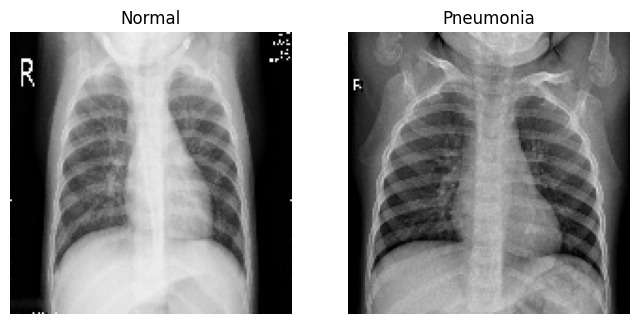

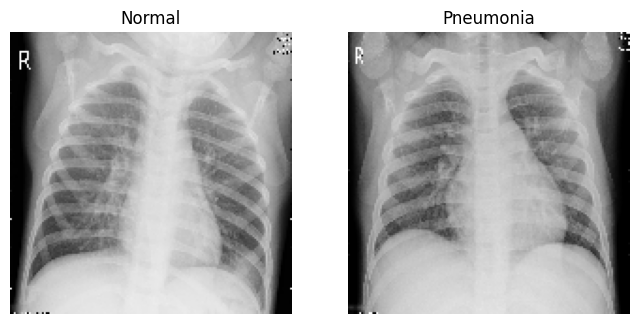

In [10]:
#Imagen de cada clase de train
fig, ax = plt.subplots(1, 2, figsize=(8, 10))
ax[0].imshow(X_train[0])
ax[0].set_title("Normal")
ax[0].axis("off")
ax[1].imshow(X_train[1])
ax[1].set_title("Pneumonia")
ax[1].axis("off")
plt.show()

#Imagen de cada clase de test
fig, ax = plt.subplots(1, 2, figsize=(8, 10))
ax[0].imshow(X_test[0])
ax[0].set_title("Normal")
ax[0].axis("off")
ax[1].imshow(X_test[1])
ax[1].set_title("Pneumonia")
ax[1].axis("off")
plt.show()

In [ ]:
# Dividir los datos en 3 clientes 
def split_data_balanced(X, y, proportions=[0.5, 0.3, 0.2]):
    """Divide los datos en 3 partes balanceadas según las proporciones indicadas."""
    clients = [[], [], []]  
    labels = [[], [], []]  
    
    # Separar los datos por clase
    X_normal = X[y == 0]
    X_pneumonia = X[y == 1]
    
    # Dividir cada clase en los 3 clientes 
    splits_normal = np.split(X_normal, [int(len(X_normal) * proportions[0]), int(len(X_normal) * (proportions[0] + proportions[1]))])
    splits_pneumonia = np.split(X_pneumonia, [int(len(X_pneumonia) * proportions[0]), int(len(X_pneumonia) * (proportions[0] + proportions[1]))])
    
    # Asignar los datos a cada cliente
    for i in range(3):
        clients[i].extend(splits_normal[i])
        clients[i].extend(splits_pneumonia[i])
        labels[i].extend([0] * len(splits_normal[i]) + [1] * len(splits_pneumonia[i]))

    clients = [np.array(c) for c in clients]
    labels = [np.array(l) for l in labels]
    
    return clients, labels

# Dividir los datos de entrenamiento en 3 clientes
clients_X, clients_y = split_data_balanced(X_train, y_train)

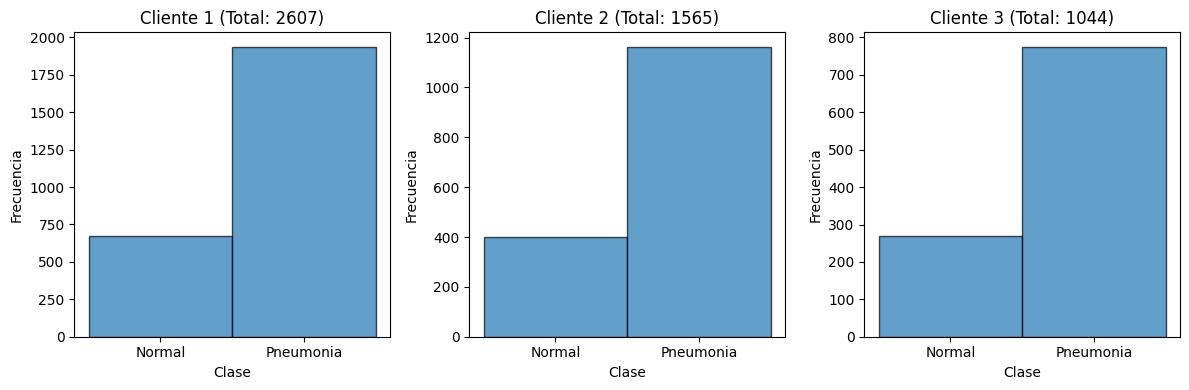

In [ ]:
# distribución de etiquetas en cada cliente
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i in range(3):
    ax[i].hist(clients_y[i], bins=np.arange(-0.5, 2, 1), edgecolor="black", alpha=0.7)
    ax[i].set_xticks([0, 1])
    ax[i].set_xticklabels(["Normal", "Pneumonia"])
    ax[i].set_title(f"Cliente {i+1} (Total: {len(clients_y[i])})")
    ax[i].set_xlabel("Clase")
    ax[i].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()

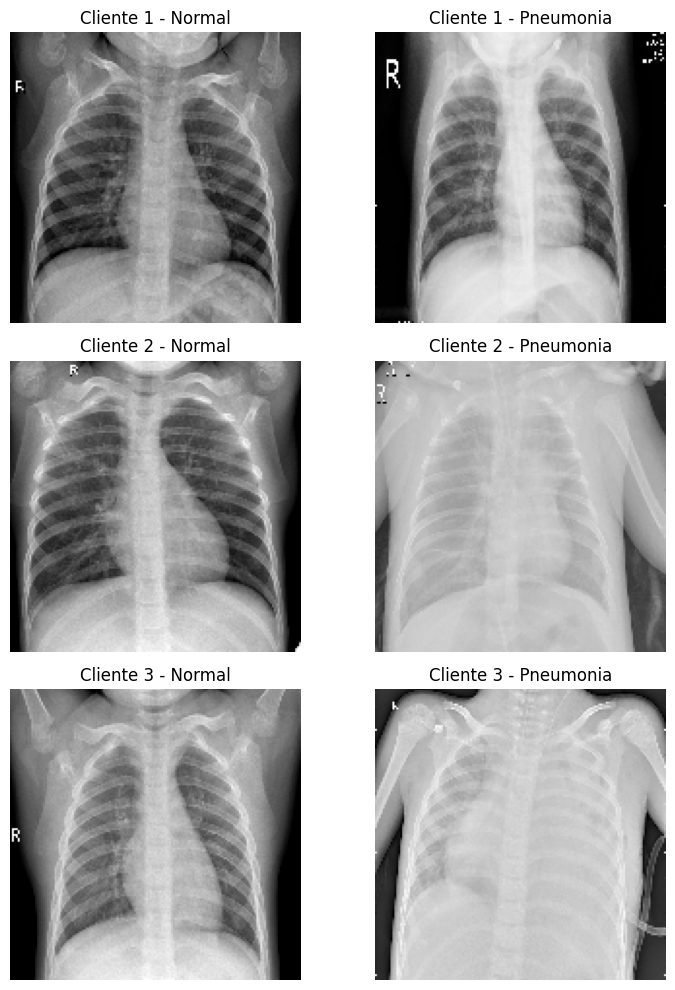

In [ ]:
#imagen de cada clase de cada cliente
fig, ax = plt.subplots(3, 2, figsize=(8, 10))

for i in range(3):
    normal_idx = np.where(clients_y[i] == 0)[0][0]  
    pneumonia_idx = np.where(clients_y[i] == 1)[0][0] 

    ax[i, 0].imshow(clients_X[i][normal_idx])
    ax[i, 0].set_title(f"Cliente {i+1} - Normal")
    ax[i, 0].axis("off")

    ax[i, 1].imshow(clients_X[i][pneumonia_idx])
    ax[i, 1].set_title(f"Cliente {i+1} - Pneumonia")
    ax[i, 1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# creación de conjuntos de entrenamiento y validación

clients_train = []
clients_val = []

# 80% entrenamiento y 20% validación para cada cliente
for i in range(3):
    X_train_client, X_val_client, y_train_client, y_val_client = train_test_split(
        clients_X[i], clients_y[i], test_size=0.2, random_state=42, stratify=clients_y[i]
    )
    clients_train.append((X_train_client, y_train_client))
    clients_val.append((X_val_client, y_val_client))

# Verificar
for i in range(3):
    print(f"Cliente {i+1} - Entrenamiento: {clients_train[i][0].shape}, Validación: {clients_val[i][0].shape}")

Cliente 1 - Entrenamiento: (2085, 150, 150, 3), Validación: (522, 150, 150, 3)
Cliente 2 - Entrenamiento: (1252, 150, 150, 3), Validación: (313, 150, 150, 3)
Cliente 3 - Entrenamiento: (835, 150, 150, 3), Validación: (209, 150, 150, 3)


In [ ]:
# Modelo 
def create_model():
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid') 
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Entrenar el modelo para un cliente y obtener la métrica de rendimiento
def train_and_evaluate(client_id, model, X_train, y_train, X_val, y_val, epochs=10):
    # Entrenar el modelo 
    model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=0)
    
    # Evaluar el modelo
    loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
    
    return model.get_weights(), accuracy

In [ ]:
# Crear un modelo global y entrenar en los datos de los clientes por 10 rondas
# Inicializar el modelo global
global_model = create_model()

rounds = 10
global_accuracies = []

# 10 rondas de aprendizaje federado
for round_num in range(rounds):
    print(f"Ronda {round_num + 1}/{rounds}")
    
    # pesos y las precisiones de cada cliente
    client_weights = []
    client_accuracies = []
    
    # Entrenar y evaluar en cada cliente
    for i in range(3):
        print(f"Entrenando en Cliente {i + 1}...")
        model_local = create_model()  
        model_local.set_weights(global_model.get_weights())  
        
        # Obtener los pesos entrenados y la precisión
        client_weights_i, accuracy = train_and_evaluate(
            i, model_local, clients_train[i][0], clients_train[i][1], clients_val[i][0], clients_val[i][1]
        )
        
        client_weights.append(client_weights_i)
        client_accuracies.append(accuracy)
    
    # promedio ponderado de los pesos 
    total_accuracy = sum(client_accuracies)
    
    # Inicializamos los pesos globales 
    weighted_weights = [np.zeros_like(weight) for weight in client_weights[0]]
    
    # la media ponderada de los pesos
    for i in range(3):
        weight_factor = client_accuracies[i] / total_accuracy  
        for j in range(len(client_weights[i])):
            weighted_weights[j] += weight_factor * client_weights[i][j]
    
    # Actualizar los pesos del modelo global
    global_model.set_weights(weighted_weights)
    
    # Guardar
    global_model.save(f"global_model_round_{round_num + 1}.h5")
    
    # Guardar la precisión global 
    global_accuracy = np.mean(client_accuracies)
    global_accuracies.append(global_accuracy)
    print(f"Precisión global en la ronda {round_num + 1}: {global_accuracy:.4f}")


Ronda 1/10
Entrenando en Cliente 1...
Entrenando en Cliente 2...
Entrenando en Cliente 3...


c:\Users\Johana Combita\.conda\envs\tensorflow\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Precisión global en la ronda 1: 0.9544
Ronda 2/10
Entrenando en Cliente 1...
Entrenando en Cliente 2...
Entrenando en Cliente 3...
Precisión global en la ronda 2: 0.9609
Ronda 3/10
Entrenando en Cliente 1...
Entrenando en Cliente 2...
Entrenando en Cliente 3...
Precisión global en la ronda 3: 0.9622
Ronda 4/10
Entrenando en Cliente 1...
Entrenando en Cliente 2...
Entrenando en Cliente 3...
Precisión global en la ronda 4: 0.9622
Ronda 5/10
Entrenando en Cliente 1...
Entrenando en Cliente 2...
Entrenando en Cliente 3...
Precisión global en la ronda 5: 0.9611
Ronda 6/10
Entrenando en Cliente 1...
Entrenando en Cliente 2...
Entrenando en Cliente 3...
Precisión global en la ronda 6: 0.9673
Ronda 7/10
Entrenando en Cliente 1...
Entrenando en Cliente 2...
Entrenando en Cliente 3...
Precisión global en la ronda 7: 0.9634
Ronda 8/10
Entrenando en Cliente 1...
Entrenando en Cliente 2...
Entrenando en Cliente 3...
Precisión global en la ronda 8: 0.9624
Ronda 9/10
Entrenando en Cliente 1...
Entren

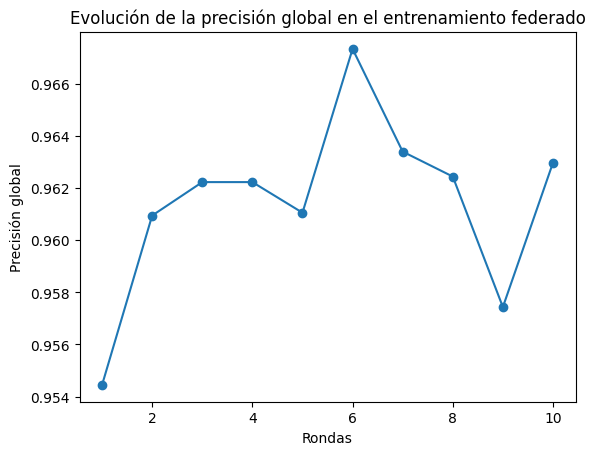

In [ ]:
#gráfica
plt.plot(range(1, rounds + 1), global_accuracies, marker='o')
plt.xlabel('Rondas')
plt.ylabel('Precisión global')
plt.title('Evolución de la precisión global en el entrenamiento federado')
plt.show()